# Comparing results from different levels of theory

This tutorial shows how to compare results from different levels of theory, including CREST, CENSO, and single-point DFT calculations on CREST geometries.

- To get started, make sure that the GEOM repo is in your path
- You'll also need to install the [Neural Force Field repository](https://github.com/learningmatter-mit/NeuralForceField) and put it in your path. We'll be using it to rapidly compare distances between conformers using batching with PyTorch

**Note: this tutorial uses the latest GEOM data generated for the MoleculeNet dataset, using both CREST and CENSO. This data will soon be released publicly.**

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# Change to your path for the GEOM repo 

import sys
sys.path.insert(0, '/home/saxelrod/Repo/projects/geom')

# Change to your Neural Force Field path

sys.path.insert(0, '/home/saxelrod/Repo/projects/master/NeuralForceField')



### Loading the CREST and CENSO data

In [3]:
from utils.compare import (load_pickle, 
                           get_all_distances, 
                           plot_geometry_changes, 
                           get_crest_censo_en_changes,
                           plot_en_changes,
                           plot_free_en_comparison,
                           get_censo_sp_en_changes,
                           plot_crest_vs_sp)
import os

In [4]:
# change to your folders for the saved conformer data

base_dir = '/home/saxelrod/rgb_nfs/GEOM/data_after_reviews'
crest_dir = os.path.join(base_dir, 'bace_water/rd_mols')
censo_dir = os.path.join(base_dir, 'censo/rd_mols')

Load the conformer information for both CREST and CENSO:

In [5]:
crest_dict = load_pickle(crest_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1511/1511 [12:17<00:00,  2.05it/s]


In [6]:
censo_dict = load_pickle(censo_dir)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 534/534 [00:07<00:00, 74.82it/s]


# Single-point calculations
### Getting acquainted with the data

Nearly all of the CREST conformers also have single-point DFT calculations, without optimization. For some of the ensembles, every conformer got an r2scan-3c/mtzvpp calculation in water. For others, the single point calculations come from the second step of CENSO. In these cases, the conformers first received less expensive b97-d3 calculations, and only those in a certain energy window recieved further r2scan-3c/mtzvpp calculations.

To get the single-point calculations, we simply have to use the `r2scan_3c_mtzvpp` key or the `'b97d3_def2_sv(p)_gas'` key for each conformer dictionary. Let's do this to see what the breakdown of single-point calculations is:

In [52]:
b97_key = 'b97d3_def2_sv(p)_gas'
r2scan_key = 'r2scan_3c_mtzvpp'

count_dic = {}

for smiles, confs in crest_dict.items():
    this_count = {"b97_count": len([conf for conf in confs if b97_key in conf]),
                  "r2scan_count": len([conf for conf in confs if r2scan_key in conf]),
                  "total_count": len([conf for conf in confs if b97_key in conf or r2scan_key in conf]),
                  "total_confs": len(confs)}
    count_dic[smiles] = this_count

b97_count = sum([val['b97_count'] for val in count_dic.values()])
r2scan_count = sum([val['r2scan_count'] for val in count_dic.values()])
total_count = sum([val['total_count'] for val in count_dic.values()])
total_confs = sum([val['total_confs'] for val in count_dic.values()])

print(f"{total_confs:,} conformers in total")


1,314,217 conformers in total


In [8]:
b97_pct = b97_count / total_confs * 100
r2scan_pct = r2scan_count / total_confs * 100
total_pct = total_count / total_confs * 100

pct_list = [val['total_count'] / val['total_confs'] * 100 for val in count_dic.values()]
lowest_3 = sorted(pct_list)[:3]
lowest_3_str = "%, ".join(['%.2f' % i for i in lowest_3])

print(f"{b97_pct:.2f}% of all conformers have b97-d3 calculations")
print(f"{r2scan_pct:.2f}% of all conformers have r2scan-3c calculations")
print(f"{total_pct:.2f}% of all conformers have either a b97-d3 or r2scan-3c calculation")
print(f"The ensembles with the lowest single-point coverage have these percentages: {lowest_3_str}%")

67.98% of all conformers have b97-d3 calculations
57.05% of all conformers have r2scan-3c calculations
99.96% of all conformers have either a b97-d3 or r2scan-3c calculation
The ensembles with the lowest single-point coverage have these percentages: 95.93%, 99.04%, 99.24%


So we see that 99.96% of all conformers have a single-point calculation, and that for all but one ensemble, over 99% of the conformers have single-point energies. The ensemble with 95.93% coverage is the only exception.

Let's look at the distribution of conformer energies in each ensemble, just as a sanity check. The r2scan-3c calculations were performed in solvent, while b97-d3 was done in gas. However, the b97-d3 also come with solvation free energies computed with xTB, so we can add those to get the effect b97-d3 energies in solution.

In [9]:
import numpy as np

b97_solv_key = b97_key.replace("gas", "water")
dft_keys = [b97_key, b97_solv_key, r2scan_key]
rel_ens = {}

for dft_key in dft_keys:
    
    rel_ens[dft_key] = []
    
    for smiles, confs in crest_dict.items():
        
        # get the absolute conformer energies in Hartree, then convert to relative energies,
        # and then convert to kcal/mol
        
        if dft_key == b97_solv_key:
            use_key = b97_key
        else:
            use_key = dft_key
            
        conf_ens = np.array([conf[use_key]['totalenergy'] for conf in confs if
                             use_key in conf])
        
        if dft_key == b97_solv_key:
            g_solv = np.array([conf[use_key]['Gsolv'] for conf in confs
                               if use_key in conf])
            conf_ens += g_solv
        
        if conf_ens.shape[0] == 0:
            continue
        conf_ens -= np.min(conf_ens)
        conf_ens *= 627.5
        
        rel_ens[dft_key] += conf_ens.tolist()
        
        


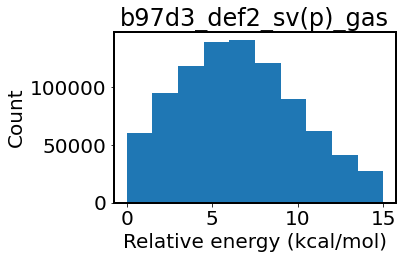

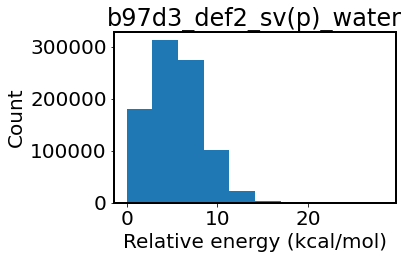

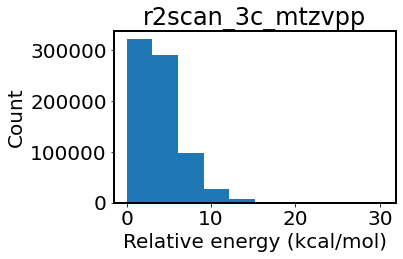

In [10]:
from matplotlib import pyplot as plt

for dft_key in dft_keys:
    
    fig, ax = plt.subplots()

    plt.hist(rel_ens[dft_key])
    plt.title(dft_key)
    plt.xlabel(f"Relative energy (kcal/mol)")
    plt.ylabel("Count")
    
    [i.set_linewidth(2) for i in ax.spines.values()]
    plt.tight_layout()
    plt.show()

The energy ranges all look reasonable! Now let's make sure that the geometries missing r2scan-3c calculations have high b97-d3 energies, justifying why they didn't need single-point calculations in CENSO:

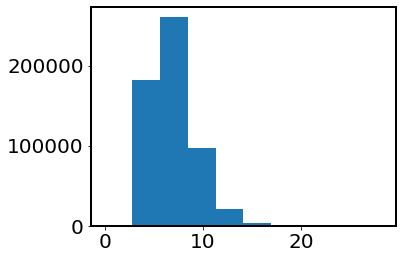

In [11]:
b97_of_missing_scan = []

for smiles, confs in crest_dict.items():
    missing_scan_confs = [conf for conf in confs if r2scan_key not in conf]
    
    b97_ens_of_missing = [conf[b97_key]['totalenergy'] + conf[b97_key]['Gsolv']
                          for conf in missing_scan_confs if b97_key in conf]
    
    all_b97_ens = [conf[b97_key]['totalenergy'] + conf[b97_key]['Gsolv']
                   for conf in confs if b97_key in conf]
    
    if not all_b97_ens or not b97_ens_of_missing:
        continue
    
    min_b97_en = min(all_b97_ens)
    rel_b97_ens = (np.array(b97_ens_of_missing) - min_b97_en) * 627.5

    
    b97_of_missing_scan += rel_b97_ens.tolist()
    
b97_of_missing_scan = np.array(b97_of_missing_scan)

fig, ax = plt.subplots()
plt.hist(b97_of_missing_scan)
[i.set_linewidth(2) for i in ax.spines.values()]
plt.tight_layout()
plt.show()


In [12]:
num_bad_missing = len(b97_of_missing_scan[b97_of_missing_scan < 4])
pct_bad_missing = num_bad_missing / total_count * 100
print((f"{num_bad_missing} conformers are missing that had relative b97 energies under 4.0 kcal/mol, "
       f"which is {pct_bad_missing:.3f}% of all conformers in the dataset."))


463 conformers are missing that had relative b97 energies under 4.0 kcal/mol, which is 0.035% of all conformers in the dataset.


So we see that 99.965% of conformers either have an r2scan-3c calculation or had relative b97-d3 energies over 4.0 kcal/mol. We're in good shape!

## Comparing CREST and r2scan-3c single-point conformer energies
Now that we've seen how to analyze some of the data, let's compare relative energies computed with r2scan-3c and xTB (through CREST). We'll do one comparison in which every geometry with an r2scan-3c energy is used. We'll also do another in which we only use ensembles that are almost completely annotated by r2scan-3c are used (i.e., >=99% of geometries have an r2scan-3c energy).

Cutoff for ensemble completeness: 0.00
MAE: 1.84 kcal/mol


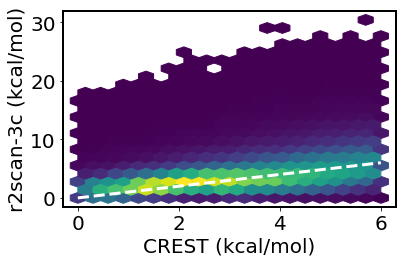

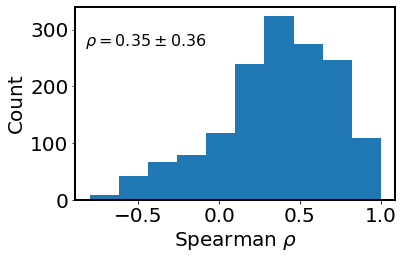

Cutoff for ensemble completeness: 0.99
MAE: 1.75 kcal/mol


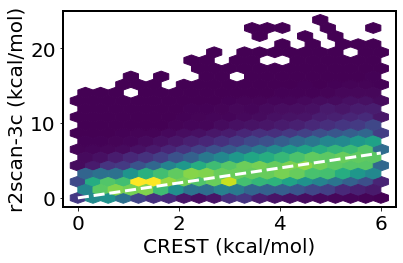

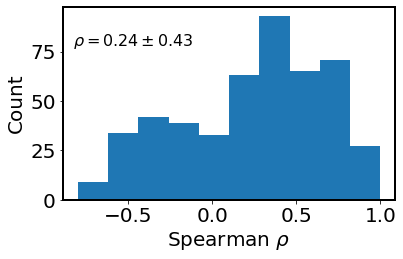

In [15]:
save_dir = '/home/saxelrod/plots'

plot_crest_vs_sp(crest_dict=crest_dict,
                 sp_key=r2scan_key,
                 save_dir=save_dir,
                 cutoffs=[0, 0.99])

We see that the average error of xTB (CREST) with respect to r2scan-3c is about 1.8 kcal/mol, consistent with benchmarks of xTB for conformational energies. There is some correlation between the ranking of conformers with CREST and with r2scan-3c (as measured through Spearman $\rho$), but it is fairly low.

## CENSO Geometry changes
Here we'll look at changes in conformer geometries when going from CREST to CENSO. We'll do this in two ways. The first way is just to look at the CREST conformer that was optimized, and see how much the geometry changed with CENSO. The second is to find the closest CREST conformer to each CENSO conformer, and then see how different they are. The second approach requires a lot of distance calculations, and so it's a bit slow.

In [16]:
out = get_all_distances(crest_dict,
                        censo_dict)

# `output_dic` contains distance information, while the last two outputs
# provide the index mapping between censo conformers and their seed conformers
# in crest (`censo_to_seed_crest`), or censo conformers and the closest
# conformer in crest (`censo_to_closest_crest`)

output_dic, censo_to_seed_crest, censo_to_closest_crest = out

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 534/534 [05:09<00:00,  1.73it/s]


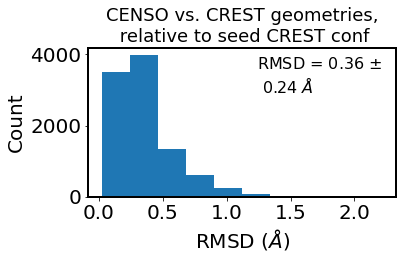

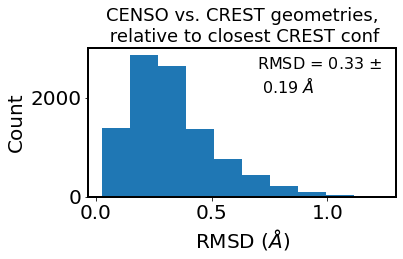

In [17]:
save_dir = '/home/saxelrod/plots'

plot_geometry_changes(output_dic,
                      save_dir=save_dir,
                      save_name="geom_compare.png")

We see that the geometry changes after optimization are quite small. Whether you're looking at how much the starting conformer changes, or how different the final CENSO conformer is from the most similar CREST conformer, the RMSD is around 0.35 Angstrom. In the former case, no RMSD is above 2 Angstrom, and in the latter case, none is above about 1 Angstrom.

## CENSO vs. single-point energies
Now let's see how much the r2scan-3c energies change after a conformer is optimized:

In [18]:
censo_sp_dic = get_censo_sp_en_changes(censo_dict,
                                       crest_dict,
                                       censo_to_seed_crest,
                                       censo_to_closest_crest,
                                       sp_key='r2scan_3c_mtzvpp')

/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/saxelrod/miniconda3/envs/htvs/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


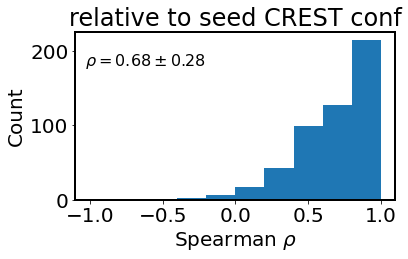

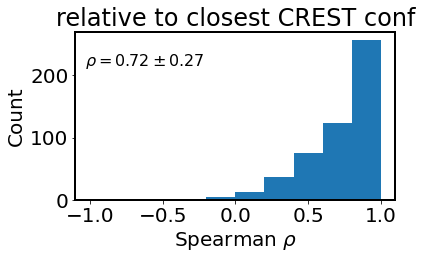

In [19]:
for name, dic in censo_sp_dic.items():

    sub_dics = dic.values()
    rhos = np.array([i['spearman'] for i in sub_dics])
    rhos = rhos[np.isfinite(rhos)]
    mean = np.mean(rhos)
    std = np.std(rhos)
    text = r"$\rho = %.2f \pm %.2f$" % (mean, std)
    
    fig, ax = plt.subplots()
    plt.hist(rhos)
    plt.text(0.03, 0.8, text, 
            transform=ax.transAxes,
            fontsize=16)
    [i.set_linewidth(2) for i in ax.spines.values()]
    plt.xlabel(r"Spearman $\rho$")
    plt.ylabel("Count")
    plt.title(name)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'rho_censo_sp_{name}.png'))
    plt.show()

## CENSO vs. CREST

Lastly, we can ask how correlated the CREST rankings are with the CENSO rankings. The results have to be interpreted with caution, however, because only the true low-energy conformers are in the CENSO ensembles. So we ignore the high-energy ones that CREST may have gotten wrong. That means the Spearman coefficient is very likely an overestimate.

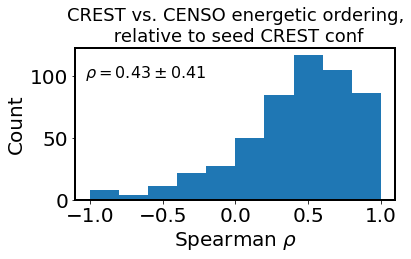

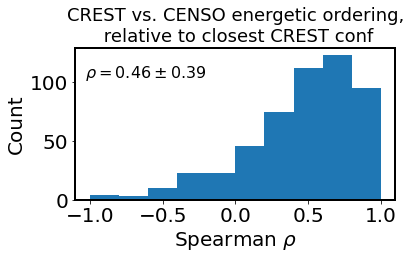

In [20]:
en_results = get_crest_censo_en_changes(censo_dict,
                                        crest_dict,
                                        censo_to_seed_crest,
                                        censo_to_closest_crest)
plot_en_changes(en_results,
                save_dir=save_dir,
                save_name='en_change.png')


## Energy vs. free energy
Lastly, let's compare the orderings based on CENSO energies to those based on CENSO free energies (which incorporate translational, rotational, and vibrational entropy, plus zero-point vibrational corrections).

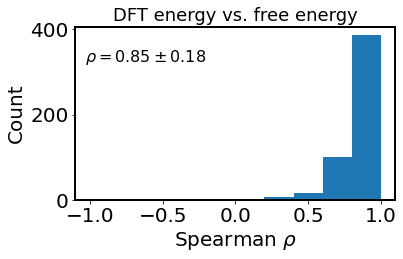

In [21]:
plot_free_en_comparison(censo_dict,
                        save_dir=save_dir,
                        save_name='rrho_contrib.png')

We see that the rankings by CENSO energy are quite well-correlated with the rankings by free energy.